## Sentiment analysis
-----
### Importing the cleaned data
---

In [61]:
%store -r game_df_cleaned
%store -r swords_df_cleaned

%store -r game_text_cleaned
%store -r swords_text_cleaned

In [62]:
!pip install afinn

Defaulting to user installation because normal site-packages is not writeable


In [63]:
from afinn import Afinn as Afinn
import re
from siuba import *
import pandas as pd
from wordcloud import *

In [64]:
afinn = Afinn()

game_text_str = ""
for _list in game_text_cleaned:
    for string in _list:
        game_text_str += string + ' '

game_df_cleaned = pd.DataFrame({
    "word": game_text_str.split()
})

swords_text_str = ""
for _list in swords_text_cleaned:
    for string in _list:
        swords_text_str += string + ' '

swords_df_cleaned = pd.DataFrame({
    "word": swords_text_str.split()
})

word_scores_swords = [afinn.score(word_) for word_ in swords_df_cleaned['word']]
swords_df_cleaned = swords_df_cleaned.assign(word_score = word_scores_swords)
# print(swords_df_cleaned)

word_scores_game = [afinn.score(word) for word in game_df_cleaned['word']]
game_df_cleaned = game_df_cleaned.assign(word_score = word_scores_game)
# print(game_df_cleaned)

### Function to break first book into chapters
------
#### Chapter 0 ----> PROLOGUE

In [65]:
chapters_first_book = ["BRAN", "CATELYN", "DAENERYS", "EDDARD", "JON", "ARYA", "TYRION", "SANSA"]
chapters_second_book = ["JAIME", "DAVOS", "SAMWELL", "BRAN", "CATELYN", "DAENERYS", "JON", "ARYA", "TYRION", "SANSA"]

# CHAPTER 0  -------> PROLOGUE
def select_chapter(dataframe, chapters):
    chapter_list = []
    curr_chapter = 0
    flag = False
    flag_epilogue = 0
    for index, row in dataframe.iterrows():
        if flag:
            curr_chapter = curr_chapter
        elif re.search("HOUSE", row['word']) and "SAMWELL" not in chapters:
            flag = True
        elif re.search("EPILOGUE", row['word']):
            flag_epilogue += 1
            if flag_epilogue > 1:
                flag = True
        elif row['word'] in chapters:
            curr_chapter += 1
        chapter_list.append(curr_chapter)
    return chapter_list


### Breaking first book in chapters ( A Game of Thrones )
---

In [66]:
game_df_cleaned = game_df_cleaned.assign(chapter = select_chapter(game_df_cleaned, chapters_first_book))
game_df_cleaned.head(150000)

,word,word_score,chapter
0,GAME,0.0,0
1,OF,0.0,0
2,THRONES,0.0,0
3,Book,0.0,0
4,Song,0.0,0
...,...,...,...
149995,steel,0.0,72
149996,music,0.0,72
149997,grew,0.0,72
149998,louder,0.0,72


### Breaking the second book in chapters ( A Storm of Swords )
---

In [67]:
swords_df_cleaned = swords_df_cleaned.assign(chapter = select_chapter(swords_df_cleaned, chapters_second_book))
swords_df_cleaned.head(150000)

,word,word_score,chapter
0,STORM,0.0,0
1,OF,0.0,0
2,SWORDS,0.0,0
3,Book,0.0,0
4,Song,0.0,0
...,...,...,...
149995,skin,0.0,80
149996,striped,0.0,80
149997,zorses,0.0,80
149998,Jogos,0.0,80


### Chapter Scores for Storm of Swords (3rd book)
---

In [68]:
swords_df_cleaned_grouped = group_by(swords_df_cleaned, 'chapter')
summarized_ss_df_swords = summarize(swords_df_cleaned_grouped, chapter_score = _.word_score.sum())
summarized_ss_df_swords.head()

,chapter,chapter_score
0,0,-238.0
1,1,-113.0
2,2,-14.0
3,3,-94.0
4,4,-69.0


### Chapter Scores for A Game of Thrones (1st book)
---

In [69]:
game_df_cleaned_grouped = group_by(game_df_cleaned, 'chapter')
summarized_ss_df = summarize(game_df_cleaned_grouped, chapter_score = _.word_score.sum())
summarized_ss_df.head()

,chapter,chapter_score
0,0,-56.0
1,1,-90.0
2,2,2.0
3,3,6.0
4,4,-9.0


### Generating a WordCloud based on chapters 50 & 51 (The Red Wedding)
----

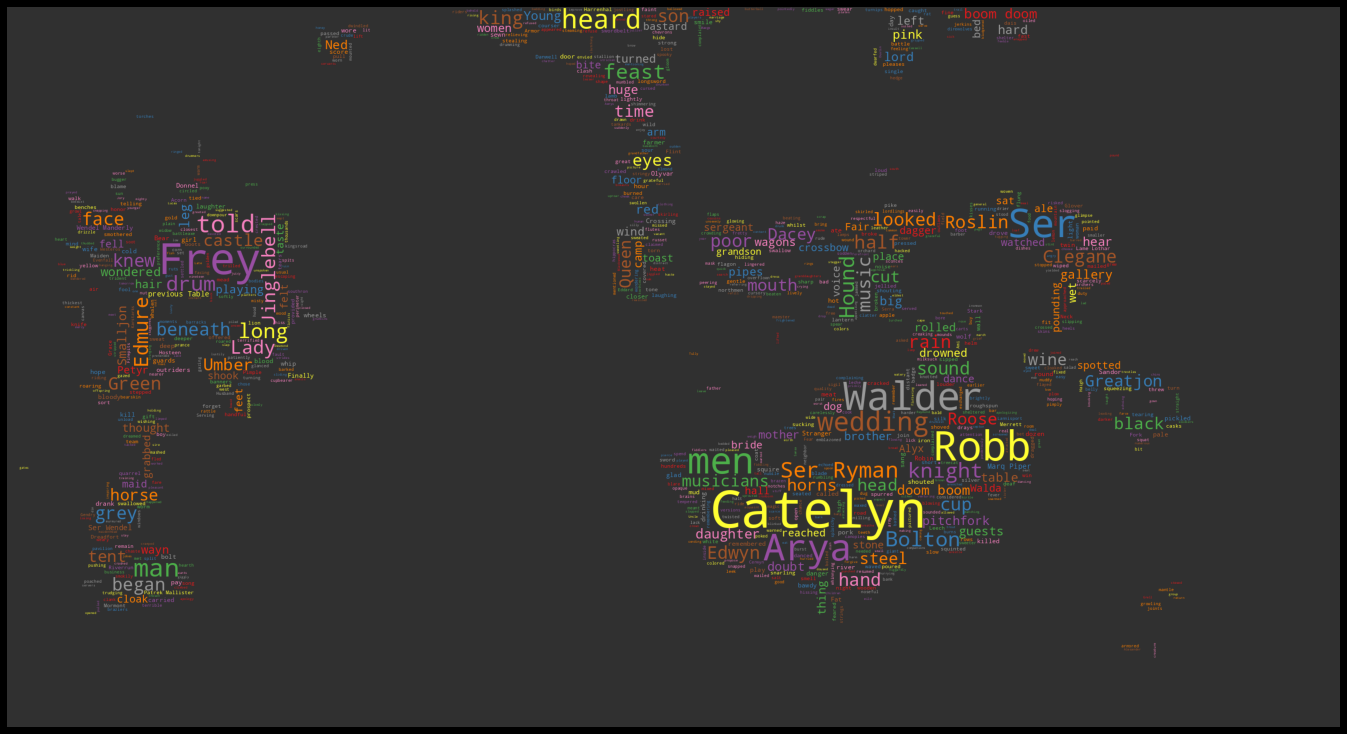

In [70]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../resources/map.png"))
mask[mask == 0] = 255

red_wedding = swords_df_cleaned[ (swords_df_cleaned['chapter'] >= 50) & (swords_df_cleaned['chapter'] <= 51) ]
text_str = ""
for str in red_wedding['word']:
    text_str += str + " "

cloudy_cloud = WordCloud(background_color="#303030", width=1600, height=800, colormap='Set1', max_words=1000, mask=mask).generate(text_str)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

### Time to compare Afinn results to NRCLex analysis
------

In [71]:
!pip install NRCLex

Defaulting to user installation because normal site-packages is not writeable


In [72]:
from nrclex import NRCLex

game_object = NRCLex(game_text_str)
swords_object = NRCLex(swords_text_str)


## Creating the NRCLex for both game_df and swords_df
------

In [73]:
game_nrclex = [NRCLex(elem).top_emotions for elem in game_df_cleaned['word']]

In [74]:
swords_nrclex = [NRCLex(elem).top_emotions for elem in swords_df_cleaned['word']]

In [75]:
game_df_ = game_df_cleaned.copy()
game_df_ = game_df_.assign(chapter = select_chapter(game_df_, chapters_first_book))
game_df_ = game_df_.assign(sentiment = game_nrclex)
game_df_

,word,word_score,chapter,sentiment
0,GAME,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
1,OF,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
2,THRONES,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
3,Book,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
4,Song,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
...,...,...,...,...
277961,Daenerys,0.0,72,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
277962,maid,0.0,72,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
277963,thirteen,0.0,72,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
277964,previous,0.0,72,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."


In [76]:
swords_df_ = swords_df_cleaned.copy()
swords_df_ = swords_df_.assign(chapter = select_chapter(swords_df_, chapters_second_book))
swords_df_ = swords_df_.assign(sentiment = swords_nrclex)
swords_df_

,word,word_score,chapter,sentiment
0,STORM,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
1,OF,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
2,SWORDS,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
3,Book,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
4,Song,0.0,0,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
...,...,...,...,...
226347,daughter,0.0,80,"[(positive, 0.5), (joy, 0.5)]"
226348,great,3.0,80,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
226349,nineteen,0.0,80,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
226350,previous,0.0,80,"[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."


## Calculating word_score / chapter in order to compare with Afinn
-------

In [77]:
test_per_chapter_game = game_df_.groupby('chapter').agg({
                             'word': ', '.join,
                             'word_score':'sum' }).reset_index() 
test_per_chapter_game[test_per_chapter_game['chapter'] == 51]
test_per_chapter_game

,chapter,word,word_score
0,0,"GAME, OF, THRONES, Book, Song, Ice, George, Ma...",-56.0
1,1,"BRAN, morning, dawned, clear, crispness, hinte...",-90.0
2,2,"CATELYN, Catelyn, born, Riverrun, Red, Fork, g...",2.0
3,3,"DAENERYS, brother, held, gown, Touch, Caress, ...",6.0
4,4,"EDDARD, visitors, poured, castle, gates, river...",-9.0
...,...,...,...
68,68,"DAENERYS, Wings, shadowed, fever, wake, walkin...",-45.0
69,69,"TYRION, Tywin, Lannister, voice, dulled, breas...",-19.0
70,70,"JON, mare, whickered, softly, Jon, Snow, tight...",-89.0
71,71,"CATELYN, years, ago, Catelyn, Stark, carried, ...",-16.0


In [78]:
test_per_chapter_swords = swords_df_.groupby('chapter').agg({
                             'word': ', '.join,
                             'word_score':'sum' }).reset_index() 
test_per_chapter_swords[test_per_chapter_swords['chapter'] == 51]
test_per_chapter_swords


,chapter,word,word_score
0,0,"STORM, OF, SWORDS, Book, Song, Ice, George, sc...",-238.0
1,1,"JAIME, east, wind, blew, tangled, soft, fragra...",-113.0
2,2,"CATELYN, Ser, Desmond, Grell, served, House, T...",-14.0
3,3,"ARYA, sky, black, walls, Harrenhal, rain, fell...",-94.0
4,4,"TYRION, woke, creak, iron, voice, raw, hoarse,...",-69.0
...,...,...,...
76,76,"JON, Jon, prowled, Satin, slow, sword, forcing...",-4.0
77,77,"TYRION, heard, noises, wooden, door, Tyrion, L...",-128.0
78,78,"SAMWELL, king, Sam, black, brothers, entered, ...",4.0
79,79,"JON, Iron, Emmett, lanky, young, ranger, sword...",-38.0


In [79]:
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from siuba import *
sia = SentimentIntensityAnalyzer()
scores = sia.polarity_scores('Yay')

In [80]:
list_game_sentiments = ['positive' if sia.polarity_scores(word)['compound'] > 0 else 'negative' if sia.polarity_scores(word)['compound'] < 0 else 'neutral' for word in game_df_['word']]
list_swords_sentiments = ['positive' if sia.polarity_scores(word)['compound'] > 0 else 'negative' if sia.polarity_scores(word)['compound'] < 0 else 'neutral' for word in swords_df_['word']]

In [81]:
game_df_ = game_df_.assign(nltk_sentiment = list_game_sentiments)
swords_df_ = swords_df_.assign(nltk_sentiment = list_swords_sentiments)

In [82]:
filtered_neg = filter(swords_df_, _.nltk_sentiment == 'negative', _.chapter == 51)
filtered_pos = filter(swords_df_, _.nltk_sentiment == 'positive', _.chapter == 51)
total = pd.concat([filtered_neg, filtered_pos])

## Creating wordclouds for the obtained data
-----
###  First of all, the negative emotions of the Chapter 51(Red Wedding)
-----

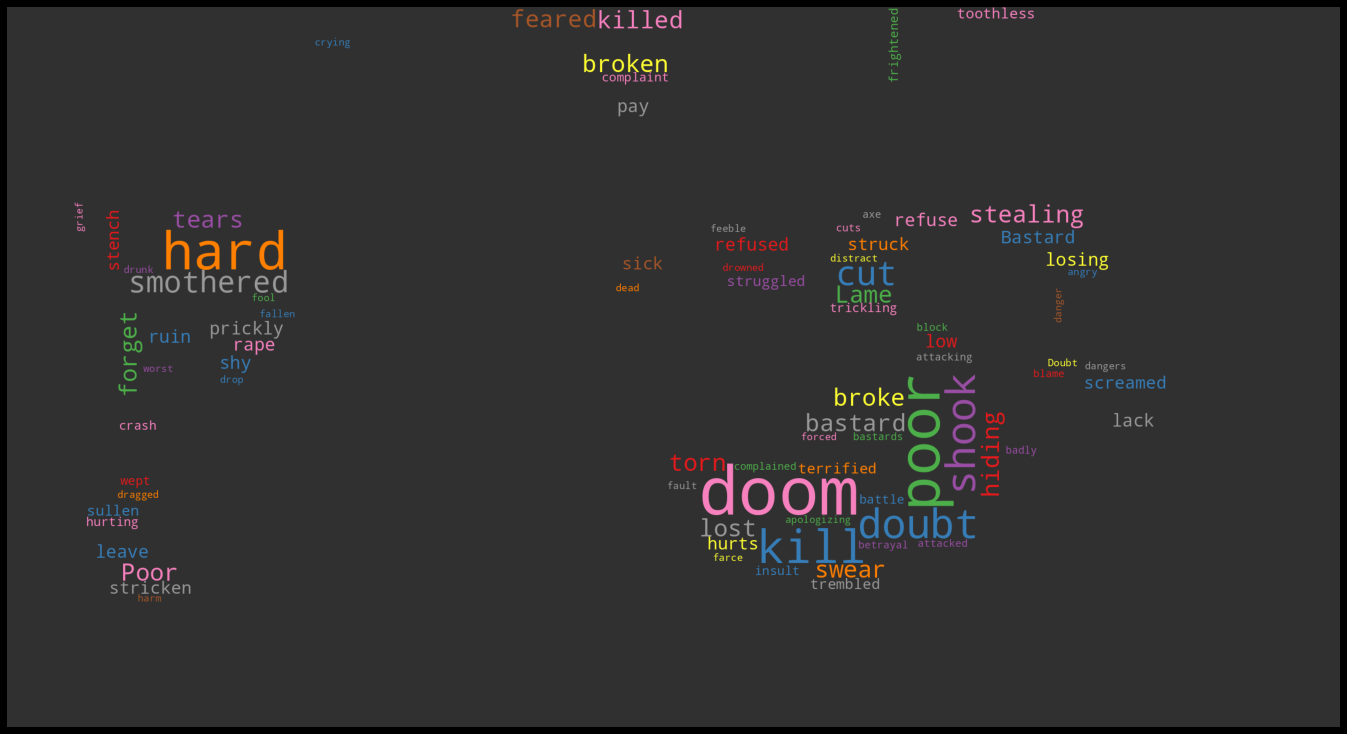

In [83]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../resources/map.png"))
mask[mask == 0] = 255
this_is_it = count(filtered_neg, 'word').sort_values('n', ascending=False).set_index('word').to_dict()

cloudy_cloud = WordCloud(background_color="#303030", width=1600, height=800, colormap='Set1', max_words=1000, mask=mask)
cloudy_cloud.generate_from_frequencies(this_is_it['n'])

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

###  Secondly, the positive emotions of the Chapter 51(Red Wedding)
-----

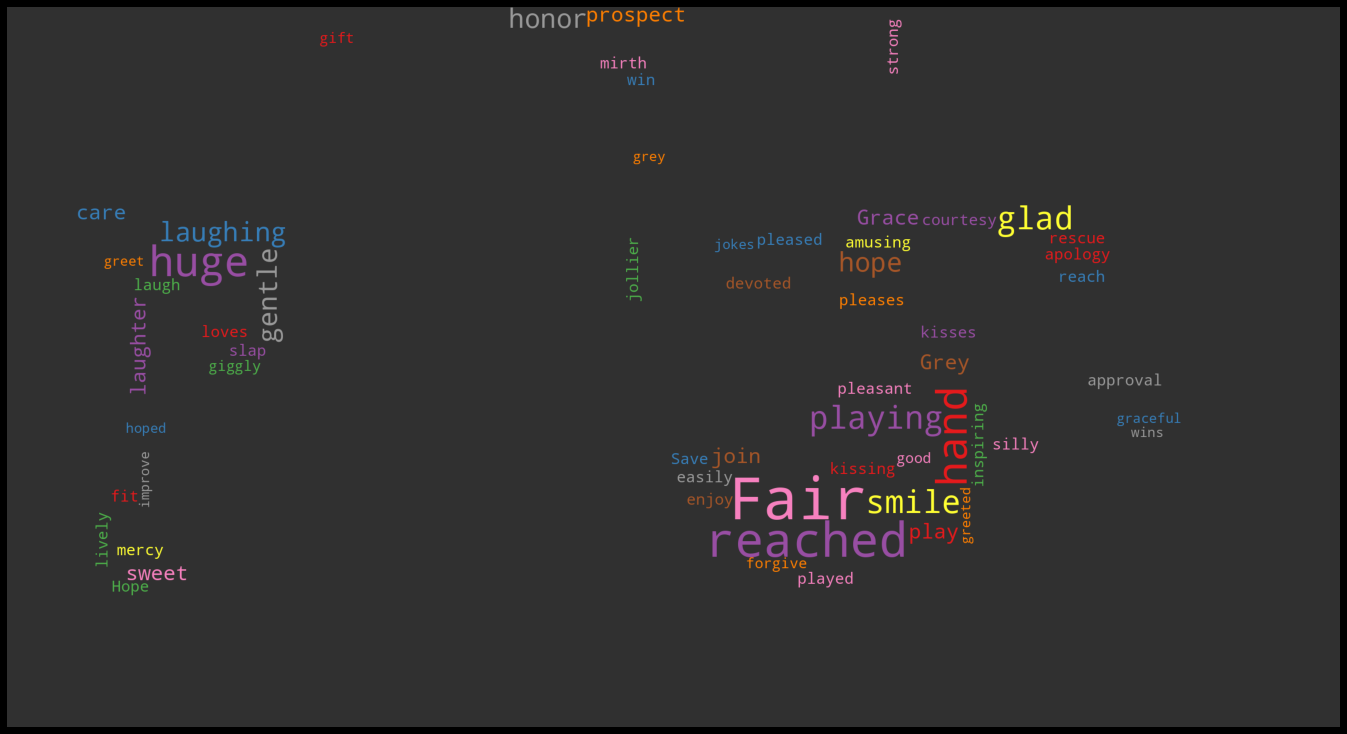

In [84]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../resources/map.png"))
mask[mask == 0] = 255
this_is_it = count(filtered_pos, 'word').sort_values('n', ascending=False).set_index('word').to_dict()

cloudy_cloud = WordCloud(background_color="#303030", width=1600, height=800, colormap='Set1', max_words=1000, mask=mask)
cloudy_cloud.generate_from_frequencies(this_is_it['n'])

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

###  Finally, the mixed emotions of the Chapter 51(Red Wedding)
-----

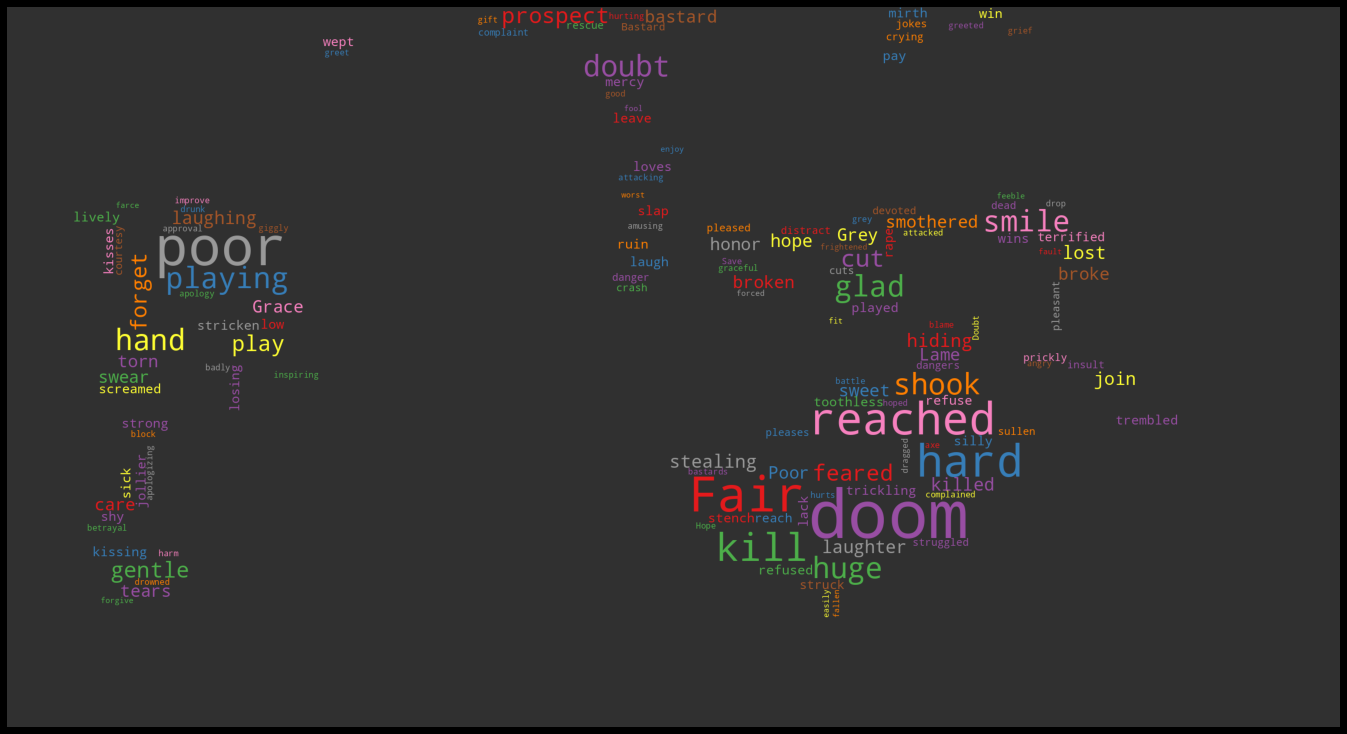

In [85]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../resources/map.png"))
mask[mask == 0] = 255
this_is_it = count(total, 'word').sort_values('n', ascending=False).set_index('word').to_dict()

cloudy_cloud = WordCloud(background_color="#303030", width=1600, height=800, colormap='Set1', max_words=1000, mask=mask)
cloudy_cloud.generate_from_frequencies(this_is_it['n'])

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud)
plt.axis("off")
plt.tight_layout(pad=0)